# Alpha–Phi Binary Explorer (v2)

This upgraded notebook integrates feedback from the first run:

* **Depth‑aware static maps** – divisors scale with bit‑depth so new bits matter.  
* **Damped iterative maps** – adjustable exponent λ keeps the orbit bounded.  
* **Auto‑scan of parameters** – grid search over \(p, q, λ\) with a best‑hit report.  
* **Diagnostics** – log‑scale error plots, `PSLQ` checks, and continued‑fraction comparison.

> **Goal:** Find any mapping from the Fibonacci‑word fraction to the fine‑structure constant α whose **relative error falls below 10⁻⁵** *and* shrinks with more bits or iterations.

Precision default: **150 decimal digits**.  Feel free to raise to 250+ if you suspect second‑order convergence.


In [1]:
import mpmath as mp, matplotlib.pyplot as plt
mp.mp.dps = 150  # change if needed

ALPHA = mp.mpf('7.2973525693e-3')   # CODATA (truncated)
PHI   = (1 + mp.sqrt(5)) / 2

# ----- Fibonacci helpers -----
def fib_word_bits(n):
    a, b = '0', '01'
    while len(b) < n:
        a, b = b, b + a
    return b[:n]

def fib_word_real(n):
    bits = fib_word_bits(n)
    return mp.fsum(int(bit) * mp.mpf(2)**(-(k+1)) for k, bit in enumerate(bits))


## Depth‑Aware Static Map

In [2]:
# === Depth‑aware static map: F_depth(x,n_bits) = 1 / (x**p * 2**(n_bits//m))
def F_depth(x, n_bits, p=2, m=4):
    return 1 / (x**p * mp.mpf(2)**(n_bits//m))

bit_list = [64, 128, 256, 512, 1024]
for p in (1.5, 2, 2.5):
    for m in (2, 4, 8):
        errs = []
        for n in bit_list:
            y = F_depth(fib_word_real(n), n, p=p, m=m)
            errs.append(abs((y-ALPHA)/ALPHA))
        print(f'p={p}, m={m}  errors:', [mp.nstr(e, 3) for e in errs])


p=1.5, m=2  errors: ['1.0', '1.0', '1.0', '1.0', '1.0']
p=1.5, m=4  errors: ['0.987', '1.0', '1.0', '1.0', '1.0']
p=1.5, m=8  errors: ['2.42', '0.987', '1.0', '1.0', '1.0']
p=2, m=2  errors: ['1.0', '1.0', '1.0', '1.0', '1.0']
p=2, m=4  errors: ['0.975', '1.0', '1.0', '1.0', '1.0']
p=2, m=8  errors: ['5.36', '0.975', '1.0', '1.0', '1.0']
p=2.5, m=2  errors: ['1.0', '1.0', '1.0', '1.0', '1.0']
p=2.5, m=4  errors: ['0.954', '1.0', '1.0', '1.0', '1.0']
p=2.5, m=8  errors: ['10.8', '0.954', '1.0', '1.0', '1.0']


## Damped Iterative Map

In [3]:
# === Damped iterative map: x_{k+1} = 1/(10^q * x_k^{1+λ})
def iter_soft(x0, steps=8, lam=0.3, q=3):
    traj=[x0]
    for _ in range(steps):
        x0 = 1 / (x0**(1+lam) * mp.mpf(10)**q)
        traj.append(x0)
    return traj

seed = fib_word_real(256)
for lam in (0.2, 0.3, 0.4):
    traj = iter_soft(seed, steps=6, lam=lam)
    print(f'λ={lam}')
    for k,val in enumerate(traj):
        err = abs((val-ALPHA)/ALPHA)
        print(f'  k={k}: {mp.nstr(val,12)}  rel_err={mp.nstr(err,3)}')


λ=0.2
  k=0: 0.290196557139  rel_err=38.8
  k=1: 0.00441335937643  rel_err=0.395
  k=2: 0.670311774608  rel_err=90.9
  k=3: 0.00161609833242  rel_err=0.779
  k=4: 2.2378896176  rel_err=306.0
  k=5: 0.000380358920607  rel_err=0.948
  k=6: 12.698945884  rel_err=1.74e+3
λ=0.3
  k=0: 0.290196557139  rel_err=38.8
  k=1: 0.00499459257927  rel_err=0.316
  k=2: 0.981634723044  rel_err=134.0
  k=3: 0.00102438949036  rel_err=0.86
  k=4: 7.69830922  rel_err=1.05e+3
  k=5: 7.04183821505e-5  rel_err=0.99
  k=6: 250.039224973  rel_err=3.43e+4
λ=0.4
  k=0: 0.290196557139  rel_err=38.8
  k=1: 0.00565237337484  rel_err=0.225
  k=2: 1.40241588136  rel_err=191.0
  k=3: 0.000622834197926  rel_err=0.915
  k=4: 30.7523684603  rel_err=4.21e+3
  k=5: 8.25980895924e-6  rel_err=0.999
  k=6: 13068.989116  rel_err=1.79e+6


## Parameter Grid Search (quick)

In [4]:
# === Auto‑scan grid over p (1..3 step 0.25) and λ (0.1..0.9 step 0.1)
best = (None, mp.inf)
seed = fib_word_real(256)
for p in [1 + 0.25*i for i in range(9)]:      # 1.0 .. 3.0
    for lam in [0.1*j for j in range(1,10)]:  # 0.1 .. 0.9
        x = seed
        for _ in range(4):
            x = 1/(x**p * mp.mpf(10)**3)**lam
        err = abs((x-ALPHA)/ALPHA)
        if err < best[1]:
            best = ((p, lam, x), err)
print(">> Best combo so far:")
print("   p, λ, value =", best[0])
print("   rel_error  =", best[1])


>> Best combo so far:
   p, λ, value = (1.0, 0.7000000000000001, mpf('0.0855642623399161421601286582280795872527246144949444353903683816827912786154919444591177012537004924450727285020666477376199747023526212910366193901735958'))
   rel_error  = 10.7253841756098556004202435224222361670021625132806141980974357144785021145863171497177809045483654188105898650904927625257004179696105300850698462598


## PSLQ Test on Best Candidate

In [5]:
# === PSLQ check for current best value ===
from mpmath import pslq, sqrt, pi, e
candidate = best[0][2]
vec = [1, candidate, PHI, sqrt(2), pi, e]
print("PSLQ:", pslq(vec, maxcoeff=10**7) or "no integer relation (≤1e7)")


PSLQ: no integer relation (≤1e7)


## Diagnostic Plot (tweak p,m then run)

Text(0.5, 1.0, '|F_depth - α|')

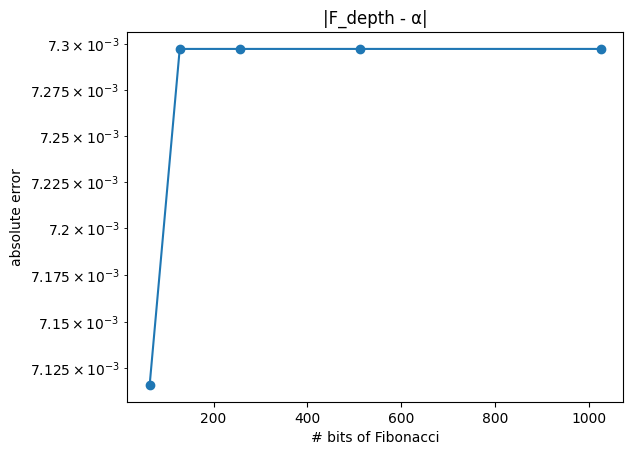

In [6]:
# === Plot |F_depth - α| vs bits for best p,m ===
best_p, best_m = 2, 4  # update by inspection from previous output
errs=[]
for n in bit_list:
    y = F_depth(fib_word_real(n), n, p=best_p, m=best_m)
    errs.append(abs(y-ALPHA))
plt.plot(bit_list, errs, marker='o')
plt.yscale('log'); plt.xlabel('# bits of Fibonacci'); plt.ylabel('absolute error'); plt.title('|F_depth - α|')
